# Temp Analysis

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [88]:
sns.set_theme()

In [89]:
TEMP_PROCESSED_FOLDER = 'data/processed/temperature/'
TEMP_GLOBAL_FILE = 'temp-land-ocean-global.csv'
TEMP_REGION_FILE = 'temp-land-region.csv'
TEMP_COUNTRY_FILE = 'temp-land-country.csv'

In [90]:
temp_global = pd.read_csv(TEMP_PROCESSED_FOLDER+TEMP_GLOBAL_FILE)
temp_region = pd.read_csv(TEMP_PROCESSED_FOLDER+TEMP_REGION_FILE)
temp_country = pd.read_csv(TEMP_PROCESSED_FOLDER+TEMP_COUNTRY_FILE)

Add smoothing

In [91]:
# applies lowess smoothing to each group
# if no group is supplied lowess will be applied to the whole dataset
def lowess_grouped(data: pd.DataFrame, x_name: str, y_name: str, group_name, frac: float):
    df = data.copy()
    y_name_smoothed = y_name + "_smooth"
    if group_name is not None:
        groups = df[group_name].unique().tolist()
        smoothed_dfs = []
        for group in groups:
            df_by_select_group = df[df[group_name] == group]
            smoothed_df = sm.nonparametric.lowess(df_by_select_group[y_name],df_by_select_group[x_name],frac=frac)
            smoothed_df = pd.DataFrame(smoothed_df)
            smoothed_df.columns = [x_name, y_name_smoothed]
            smoothed_df[x_name] = smoothed_df[x_name].astype(int)
            smoothed_df[group_name] = group
            smoothed_dfs.append(smoothed_df)
        return pd.merge(df,pd.concat(smoothed_dfs), how="left", on=[x_name,group_name])
    else:
        smoothed_df = sm.nonparametric.lowess(df[y_name], df[x_name], frac=frac)
        smoothed_df = pd.DataFrame(smoothed_df)
        smoothed_df.columns = [x_name, y_name_smoothed]
        return pd.merge(df,smoothed_df, how="left", on=x_name)

In [92]:
temp_global = lowess_grouped(temp_global, "year", "temperature_anomaly", None, frac=0.05)
temp_region = lowess_grouped(temp_region, "year", "temperature_anomaly", "region_name", frac=0.05)
temp_country = lowess_grouped(temp_country, "year", "temperature_anomaly", "country_name", frac=0.05)

## Global temperature trend

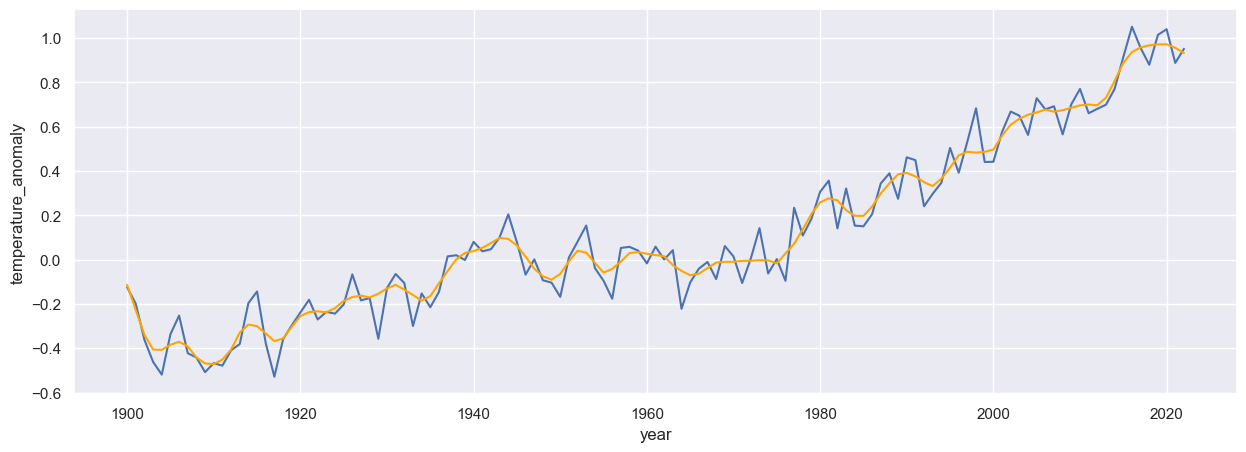

In [93]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="year", y="temperature_anomaly", data=temp_global)
sns.lineplot(x="year", y="temperature_anomaly_smooth", data=temp_global, color="orange");

## Temperature trend per regions

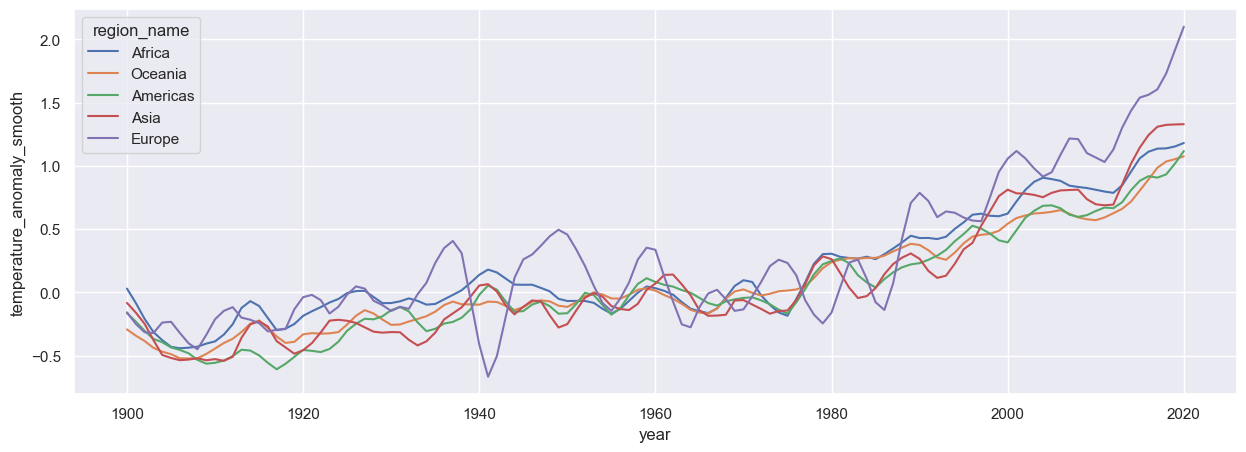

In [94]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="year", y="temperature_anomaly_smooth", hue="region_name", data=temp_region, ax=ax);

=> Europe seems to be more extreme than the rest

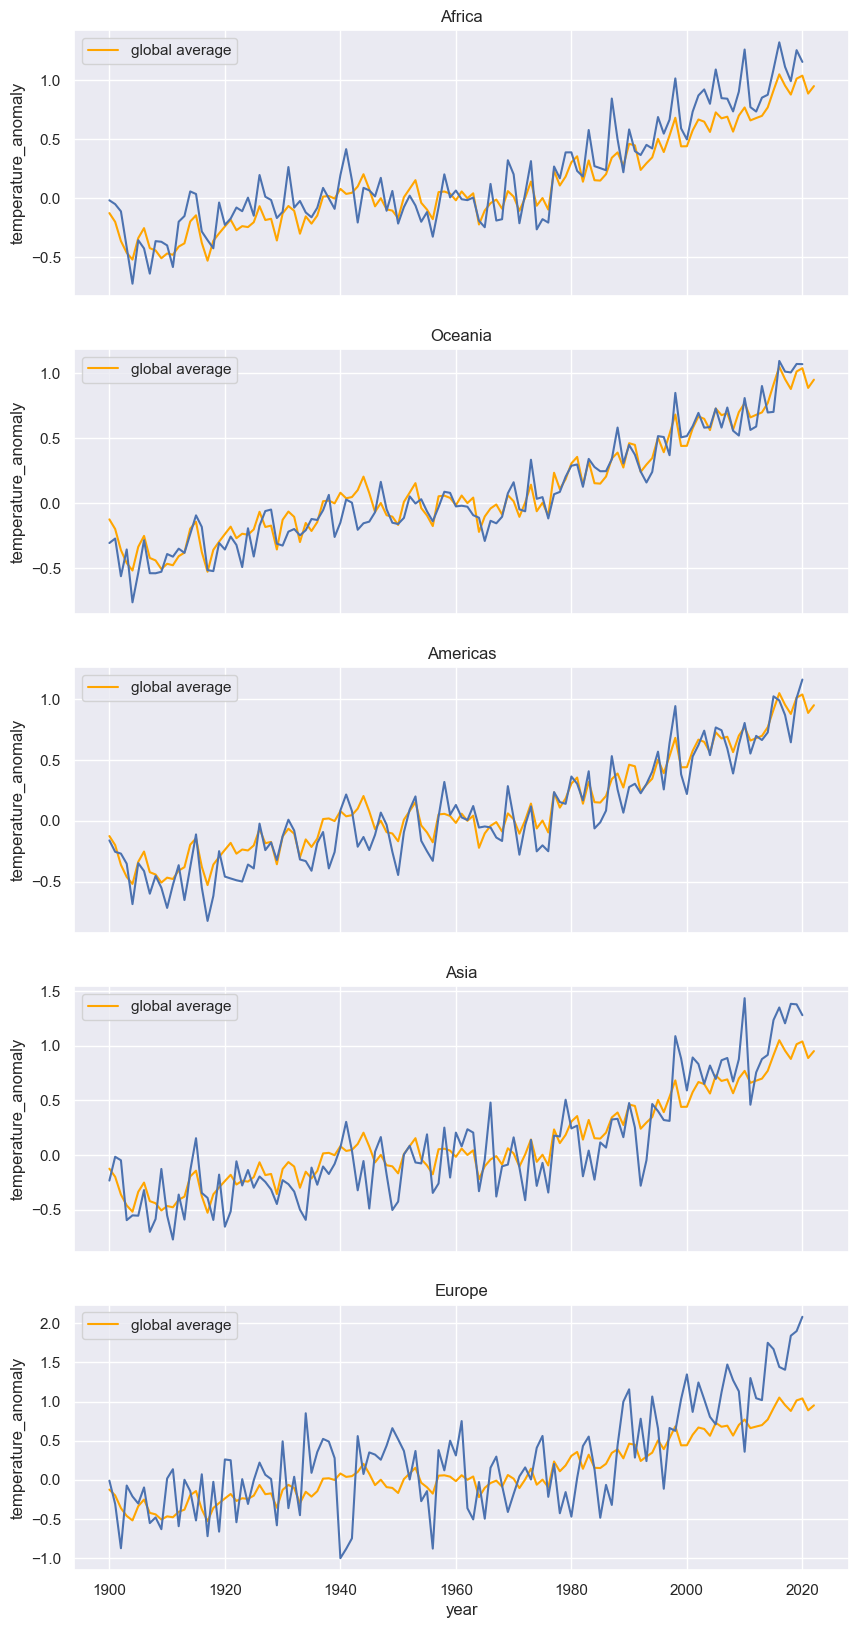

In [95]:
temp_regions = temp_region["region_name"].unique().tolist()
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(10, 20))
for i, region in enumerate(temp_regions):
    sns.lineplot(x="year", y="temperature_anomaly", data=temp_global, ax=axes[i], color='orange', label="global average")
    sns.lineplot(x="year", y="temperature_anomaly", data=temp_region[temp_region["region_name"] == region], ax=axes[i])
    axes[i].set_title(region)
    axes[i].legend()

## Look at a single country (Austria)

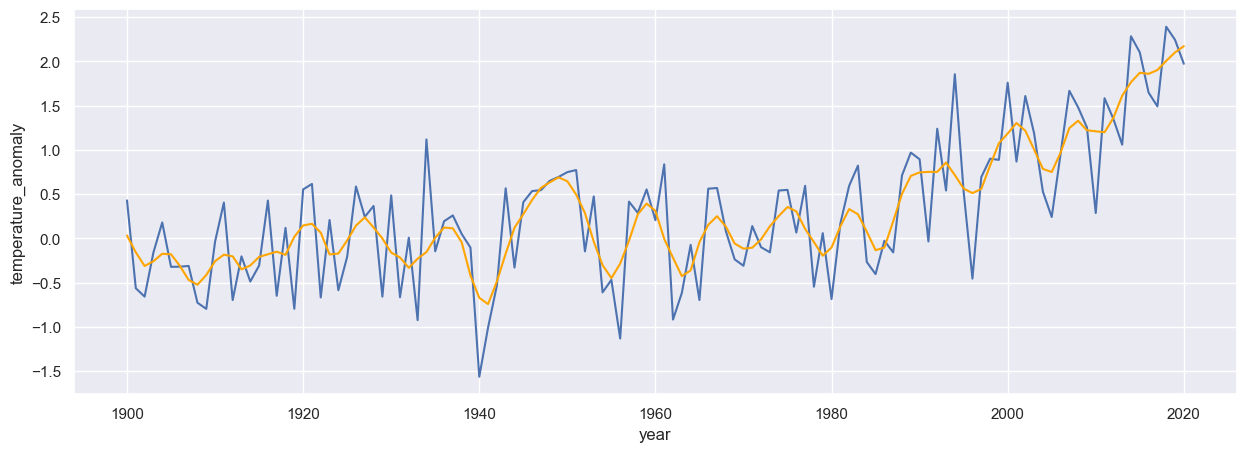

In [96]:
temp_aut = temp_country[temp_country["country_code"] == "AUT"]
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="year",y="temperature_anomaly",data=temp_aut, ax=ax)
sns.lineplot(x="year",y="temperature_anomaly_smooth",data=temp_aut, ax=ax, color="orange");

## Are some Countries extremer than others?

In [97]:
temp_country[temp_country["year"] == 2020].sort_values(by=["temperature_anomaly_smooth"], ascending=False).head()

,year,country_code,temperature_anomaly,country_name,temperature_anomaly_smooth
27238,2020,LVA,3.315083,Latvia,3.265715
27186,2020,EST,3.403417,Estonia,3.244439
27276,2020,RUS,3.627500,Russia,3.186368
27236,2020,LTU,3.134333,Lithuania,3.181848
27157,2020,BLR,3.101917,Belarus,3.137251


In [98]:
temp_country[temp_country["year"] == 2020].sort_values(by=["temperature_anomaly_smooth"], ascending=False).tail()

,year,country_code,temperature_anomaly,country_name,temperature_anomaly_smooth
27279,2020,SDN,0.528083,Sudan,0.595429
27136,2020,AFG,0.379750,Afghanistan,0.549394
27263,2020,PAK,0.531750,Pakistan,0.492607
27210,2020,IND,0.430750,India,0.485394
27260,2020,NPL,0.323667,Nepal,0.366796


In [99]:
def plot_countries_temp_anomalies(temp_countries):
    fig, ax = plt.subplots(figsize=(15, 5))
    for i,country_code in enumerate(temp_countries):
        temp_selected_country = temp_country[temp_country["country_code"] == country_code]
        selected_country_name = temp_selected_country["country_name"].iloc[0]
        sns.lineplot(x="year",y="temperature_anomaly_smooth",data=temp_selected_country, ax=ax, label=selected_country_name)
    ax.legend();

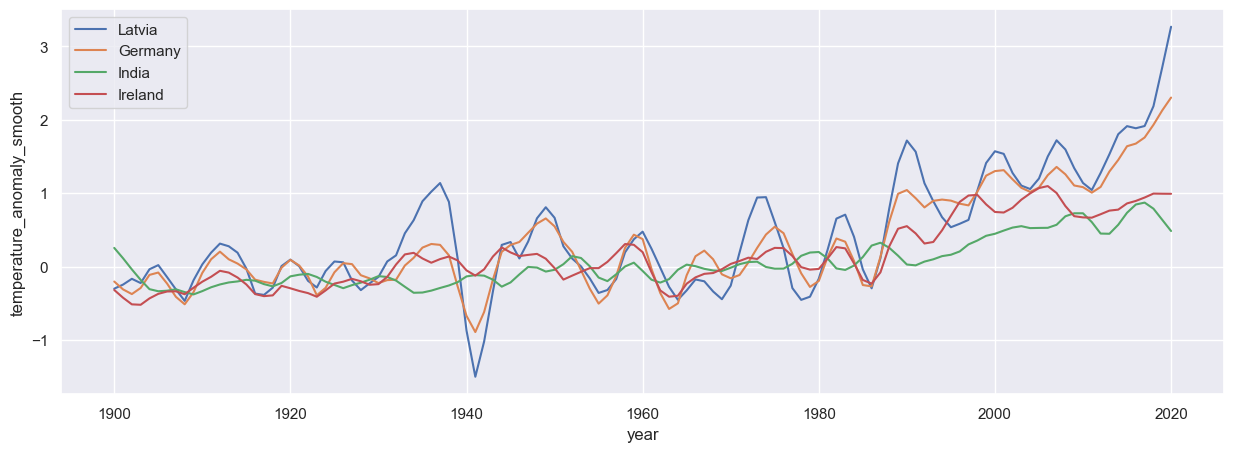

In [100]:
# choose countries that have large increase in temperature_anomaly, and some that have small increase
temp_extreme_countries = ["LVA","DEU","IND","IRL"]
plot_countries_temp_anomalies(temp_extreme_countries)

## Can we see something if we apply linear regression per country?

In [101]:
temp_regression_countries = []
for country_code in temp_country["country_code"].unique().tolist():
    result = smf.ols(formula="temperature_anomaly ~ year", data=temp_country[temp_country["country_code"] == country_code]).fit()
    temp_regression_countries.append([country_code,result.params["year"]])
temp_regression_countries = pd.DataFrame(temp_regression_countries)
temp_regression_countries.columns = ["country_code","year_slope"]
temp_regression_countries.sort_values(by=["year_slope"],ascending=False)

,country_code,year_slope
135,MNG,0.018051
228,ATA,0.017874
177,SJM,0.017829
106,KGZ,0.016326
104,KAZ,0.016276
...,...,...
185,STP,0.008036
41,COG,0.007833
93,IND,0.007577
129,MEX,0.007145


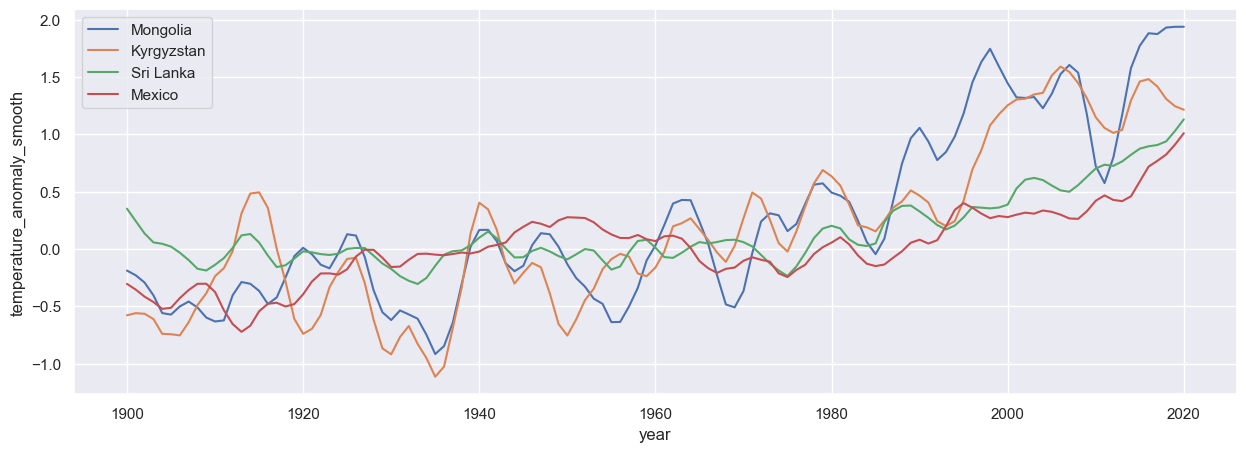

In [102]:
temp_extreme_countries = ["MNG","KGZ","LKA","MEX"]
plot_countries_temp_anomalies(temp_extreme_countries)

=> cant really see something meaningful here

## Second Approach to find extreme countries

### Are there outliers in the temperature anomalies

Yes we can see in the Boxplot that outliers exist.

We want to know at which value we can consider an temperature anomaly to be an outlier.

Therefore we will calculate upper and lower bounds for temperature anomalies using IQR in the following steps.

<AxesSubplot: >

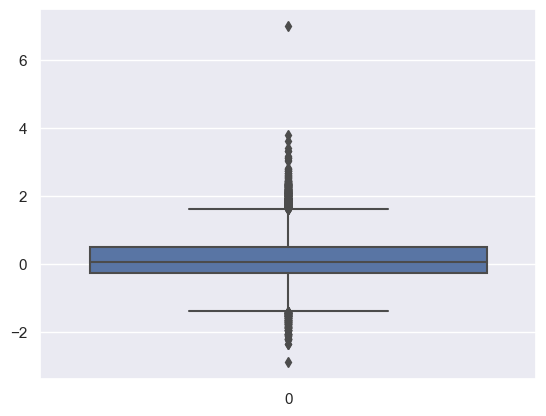

In [103]:
sns.boxplot(temp_country['temperature_anomaly'])

### Calculate temperature anomaly IQR

In [104]:
temp_anomalies_np_arr = temp_country['temperature_anomaly'].to_numpy()
temp_anomalies_q3 = np.quantile(temp_anomalies_np_arr, 0.75)
temp_anomalies_q1 = np.quantile(temp_anomalies_np_arr, 0.25)
IQR = temp_anomalies_q3 - temp_anomalies_q1
IQR

0.7557916666666666

#### Calculate upper/lower bound for temp anomaly outliers using IQR

In [105]:
temp_anomaly_upper_bound = temp_anomalies_q3 + 1.5 * IQR
temp_anomaly_lower_bound = temp_anomalies_q1 - 1.5 * IQR
print(temp_anomaly_upper_bound)
print(temp_anomaly_lower_bound)

1.6220625
-1.4011041666666666


#### Detect extreme countries counting outliers based on IQR bounds

1. we filter for countries which include temperature anomaly outliers

2. we count the temperature anomaly outliers for each country and sort them by outlier count

In [106]:
temp_countries_anomaly_outlier = temp_country[(temp_country['temperature_anomaly'] >= temp_anomaly_upper_bound)
                                              | (temp_country['temperature_anomaly'] <= temp_anomaly_lower_bound)][['country_code', 'temperature_anomaly']]

temp_countries_anomaly_outlier = temp_countries_anomaly_outlier.groupby(['country_code']).count().sort_values(['temperature_anomaly'], ascending=False)
temp_countries_anomaly_outlier

,temperature_anomaly
country_code,
SJM,32
FIN,29
EST,25
LVA,22
LTU,22
...,...
MLI,1
SDN,1
MLT,1


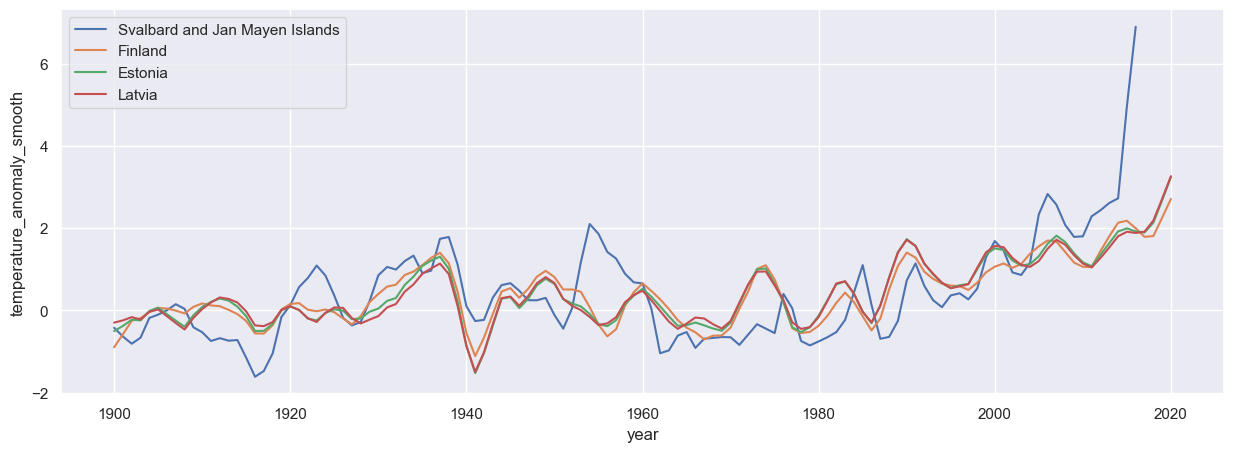

In [110]:
temp_extreme_countries = ["SJM","FIN","EST","LVA"]
plot_countries_temp_anomalies(temp_extreme_countries)